In [1]:
import sys
import json
sys.path.append("/global/homes/s/seanjx/gigalens/src")

import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp

from astropy.io import fits
from astropy.visualization import simple_norm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Plots.model_plot as model_plot
from lenstronomy.Util import util

from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import myfunctions

In [2]:
#load observation data, do masking
f=fits.open('psf246.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout246.npy")

f=fits.open('final_96_drz.fits')
background_rms=0.00788315
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

In [3]:
path = "output/"+"246_2024-07-16 15:59:57.476532"
prior, phys_model, phys_model_Forward, SingleSources = myfunctions.readJson(path+"/prior.json")[0:4]
err_map = np.load(path+"/err_map.npy")

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
try: 
    #raise("I actually want MAP")
    inputFile = open(path+"/bestHMC.json")
    best_HMC = json.load(inputFile)
    print("HMC loaded")
    MAPorHMC = "HMC"
except: 
    prob_model = BackwardProbModel(prior, observed_img, err_map, background_rms=background_rms, exp_time=exp_time)
    best = np.load(path+"/best.npy")
    best_HMC = prob_model.bij.forward(best.tolist()[0])
    MAPorHMC = "MAP"
    print("MAP loaded")

HMC loaded


In [4]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

62 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SHAPELETS', 'SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [5]:
for ii, thing in enumerate(best_HMC):
    for iii, thing2 in enumerate(thing):
        for iv in thing2:
            best_HMC[ii][iii][iv] = float(best_HMC[ii][iii][iv])

In [6]:
plt.style.use('default')
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)

kwargs_data = sim_util.data_configure_simple(numPix*2, deltaPix)
data = ImageData(**kwargs_data)
_coords = data
lensModel = LensModel(lens_model_list=priorObjects[0])
kwargs_lens = best_HMC[0]
print(kwargs_lens)
extent = (-numPix/2*deltaPix, numPix/2*deltaPix, -numPix/2*deltaPix, numPix/2*deltaPix)
scale_length = 1 #arcsec

def convertEllipticity(e1, e2):
    phi = jnp.arctan2(e2, e1) / 2
    c = jnp.minimum(jnp.sqrt(e1 ** 2 + e2 ** 2), 0.9999)
    q = (1 - c) / (1 + c)
    return float(q), float(phi)

print(best_HMC[0][0]['e1'],best_HMC[0][0]['e2'])
print(convertEllipticity(best_HMC[0][0]['e1'],best_HMC[0][0]['e2']))

[{'theta_E': 2.732290744781494, 'gamma': 2.5210108757019043, 'e2': 0.22459836304187775, 'e1': 0.05021997541189194, 'center_y': -0.06313744187355042, 'center_x': 0.09257788956165314}, {'gamma2': 0.039298199117183685, 'gamma1': -0.05461200326681137}]
0.05021997541189194 0.22459836304187775
(0.6258253455162048, 0.675407886505127)


In [7]:
mass = best_HMC[0]
lens_light = best_HMC[1]
source_light = best_HMC[2]
for ii, thing in enumerate(lens_light):
    thing["Ie"] = float(coeffs[0][ii]*1/deltaPix**2)

counter = ii+1
for ii, thing in enumerate(source_light):
    if priorObjects[2][ii] == "SHAPELETS":
        n_max = phys_model.getProfiles()[2][ii].n_max
        #n_max = 5
        n_layers = int((n_max + 1) * (n_max + 2) / 2)
        decimal_places = len(str(n_layers))
        amps = []
        for iii in range(n_layers):
            amps.append(f"amp{str(iii).zfill(decimal_places)}")
            thing[amps[iii]]=np.array([coeffs[0][counter]*1/deltaPix**2])
            counter = counter + 1
    else:
        thing["Ie"] = float(coeffs[0][counter]*1/deltaPix**2)
        counter = counter + 1

lens_sim_deconstructed = LensSimulator(phys_model_Forward, sim_config, bs=1)

sourcesimulated = lens_sim_deconstructed.simulate([[], [], source_light])
masssimulated = lens_sim_deconstructed.simulate([mass, [], source_light])
lenssimulated = lens_sim_deconstructed.simulate([[], lens_light, []])

individualSourceSimulations = []
for ii, source in enumerate(source_light):
    OneSourceModel = LensSimulator(SingleSources[ii], sim_config, bs=1)
    individualSourceSimulations.append(OneSourceModel.simulate([mass, [], [source]]))    


In [8]:
print(best_HMC)
print(phys_model.getProfiles()[2][0].n_max,phys_model.getProfiles()[2][1].n_max)

[[{'theta_E': 2.732290744781494, 'gamma': 2.5210108757019043, 'e2': 0.22459836304187775, 'e1': 0.05021997541189194, 'center_y': -0.06313744187355042, 'center_x': 0.09257788956165314}, {'gamma2': 0.039298199117183685, 'gamma1': -0.05461200326681137}], [{'n_sersic': 3.0254693031311035, 'e2': -0.016427814960479736, 'e1': 0.22424349188804626, 'center_y': -0.03915685415267944, 'center_x': -0.06362037360668182, 'R_sersic': 1.3081326484680176, 'Ie': 50.21901321411133}, {'n_sersic': 1.2223854064941406, 'e2': -0.02996233105659485, 'e1': 0.27226704359054565, 'center_y': -0.012312976643443108, 'center_x': -0.0353693887591362, 'R_sersic': 1.040306806564331, 'Ie': -34.727848052978516}, {'n_sersic': 2.766707181930542, 'e2': 0.28631943464279175, 'e1': -0.2560652494430542, 'center_y': 0.07455476373434067, 'center_x': 3.1006364822387695, 'R_sersic': 0.1739393025636673, 'Ie': 33.440547943115234}, {'n_sersic': 3.026125192642212, 'e2': -0.049239739775657654, 'e1': -0.021222606301307678, 'center_y': -2.922

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_70224/3797560808.py:24: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")


1.2207541


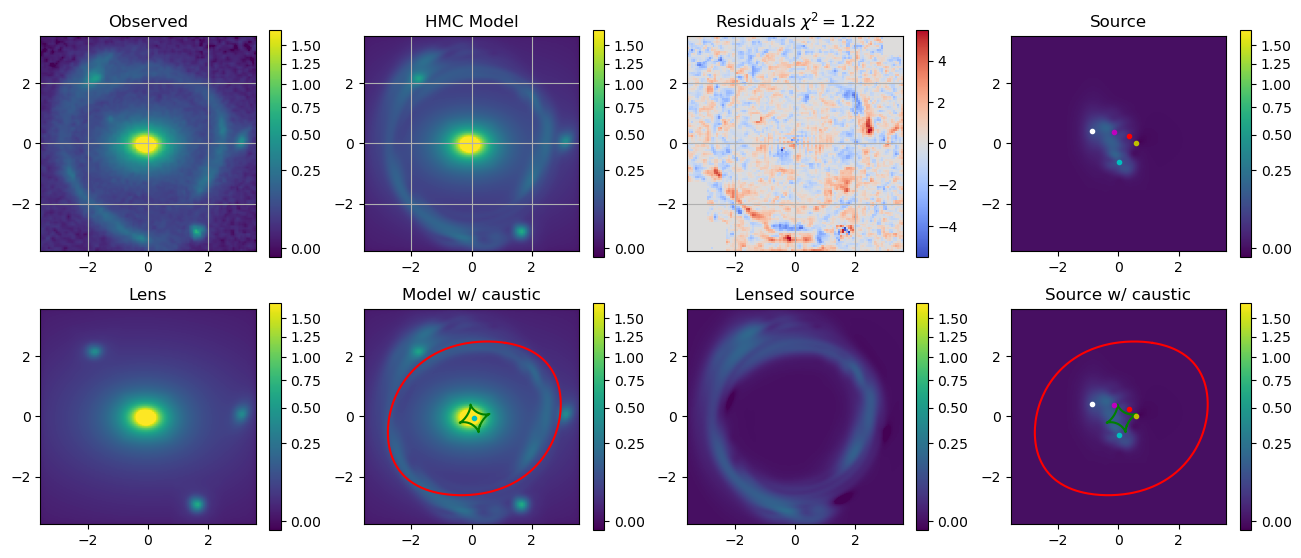

In [9]:
plt.figure(figsize=(16, 6.5))
colors = ["c.","m.","y.","w.","r.","k."]
norm = simple_norm(observed_img, 'sqrt', percent=99.)

resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

plt.subplot(241)
plt.imshow(observed_img, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Observed")
plt.colorbar()
plt.grid(which='major')

ax = plt.subplot(242)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title(MAPorHMC+" Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(243)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(244)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(245)
plt.imshow(lenssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lens")
plt.colorbar()

ax = plt.subplot(246)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
for ii in range(0,len(mass)):
    try:
        plt.plot(mass[ii]["center_x"],mass[ii]["center_y"],colors[ii])
    except:
        pass
plt.title("Model w/ caustic")
plt.colorbar()

plt.subplot(247)
plt.imshow(masssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

ax = plt.subplot(248)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source w/ caustic")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"output.png")
print(HMCchi)

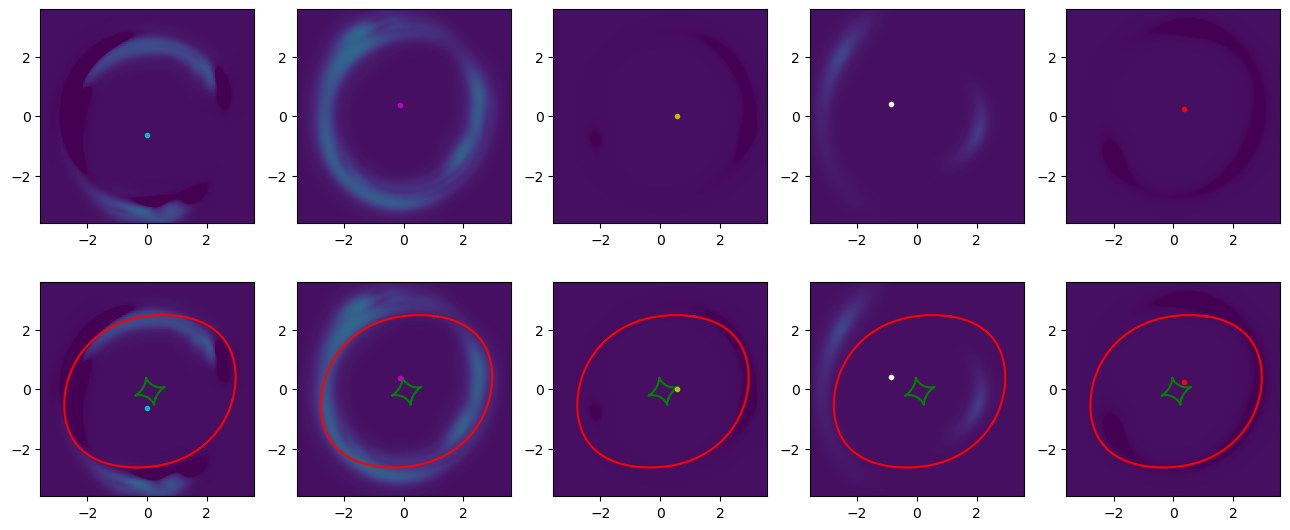

In [10]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1+len(source_light))
    lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')

plt.savefig(path+"/"+MAPorHMC+"deconstructed.png")

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_70224/3492142694.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")


-0.011272475
-0.0029741777


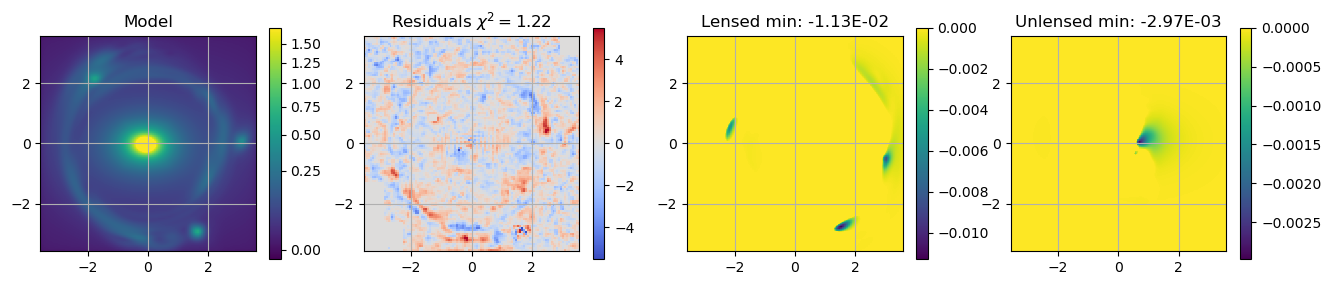

In [11]:
plt.figure(figsize=(16,3))

ax = plt.subplot(141)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(142)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(143)
plt.imshow(masssimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Lensed min: {np.min(masssimulated):.2E}")
print(np.min(masssimulated))

plt.subplot(144)
plt.imshow(sourcesimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Unlensed min: {np.min(sourcesimulated):.2E}")
print(np.min(sourcesimulated))

plt.savefig(path+"/"+MAPorHMC+"negativedetection.png")

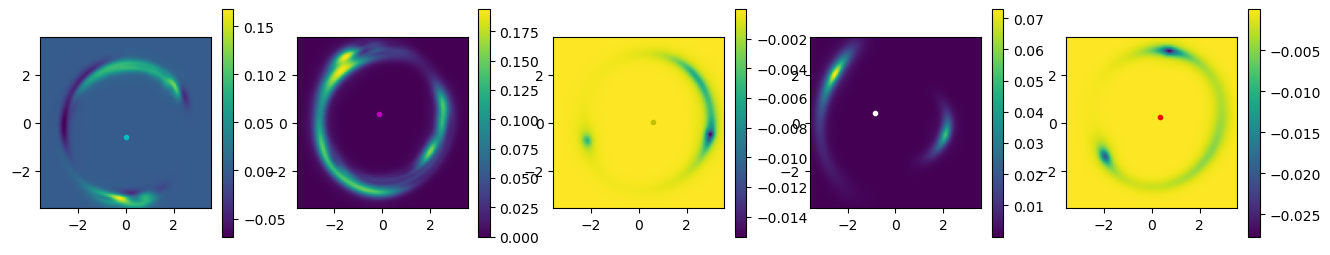

In [12]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], extent=extent, origin='lower')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.colorbar()

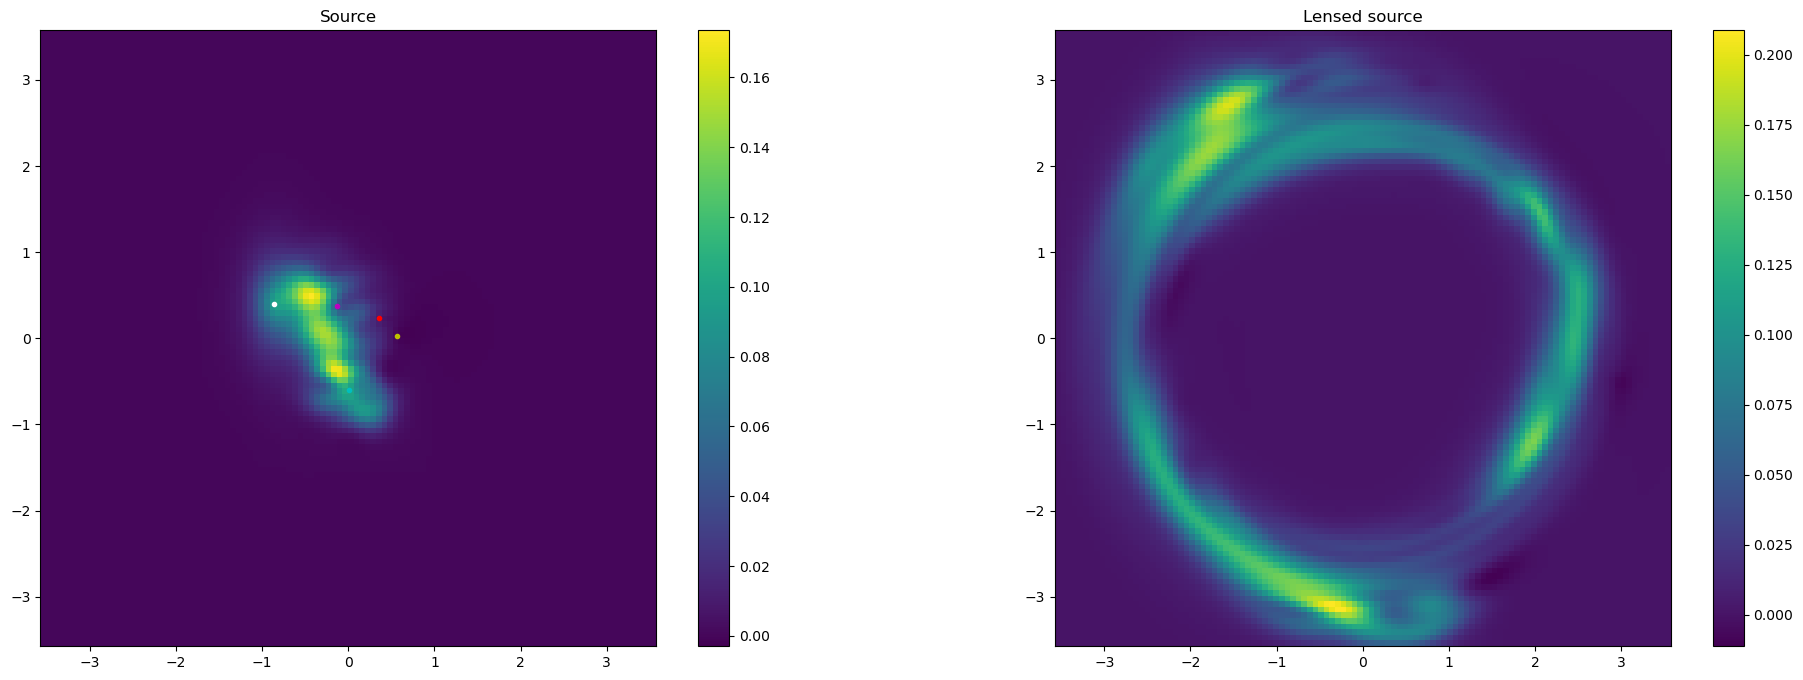

In [13]:
plt.figure(figsize=(24,8))
plt.subplot(121)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(122)
plt.imshow(masssimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

Text(0.5, 1.0, 'kappa (log)')

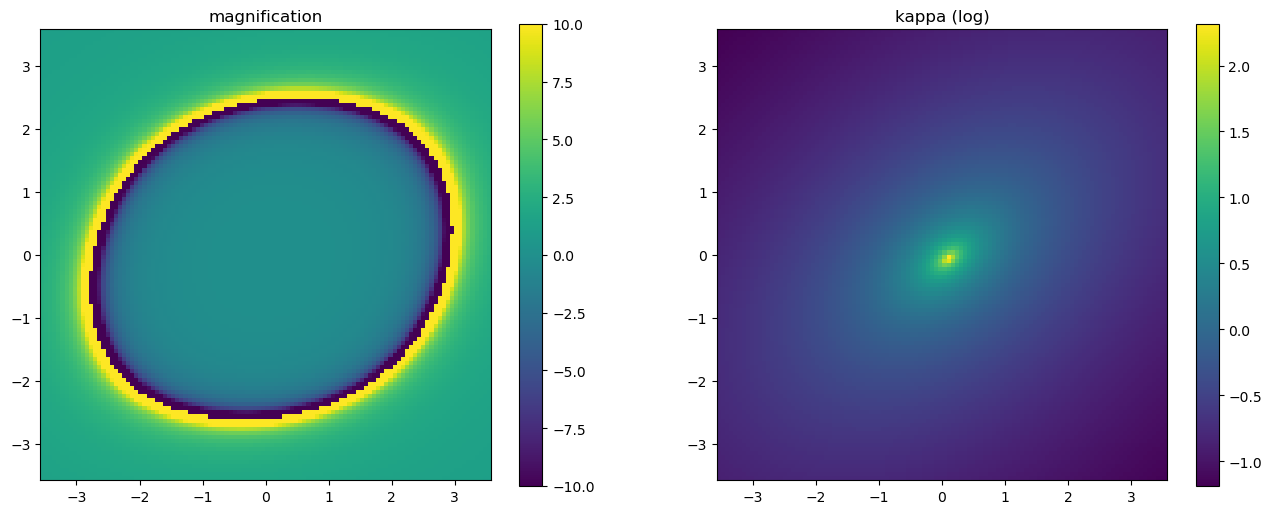

In [14]:
x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltaPix)

mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_lens)
mag2d = util.array2image(mag_grid)

kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_lens)
kappa2d = util.array2image(kappa_grid)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(mag2d, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")

plt.subplot(122)
plt.imshow(np.log10(kappa2d), origin='lower',extent=extent)
plt.colorbar()
plt.title("kappa (log)")

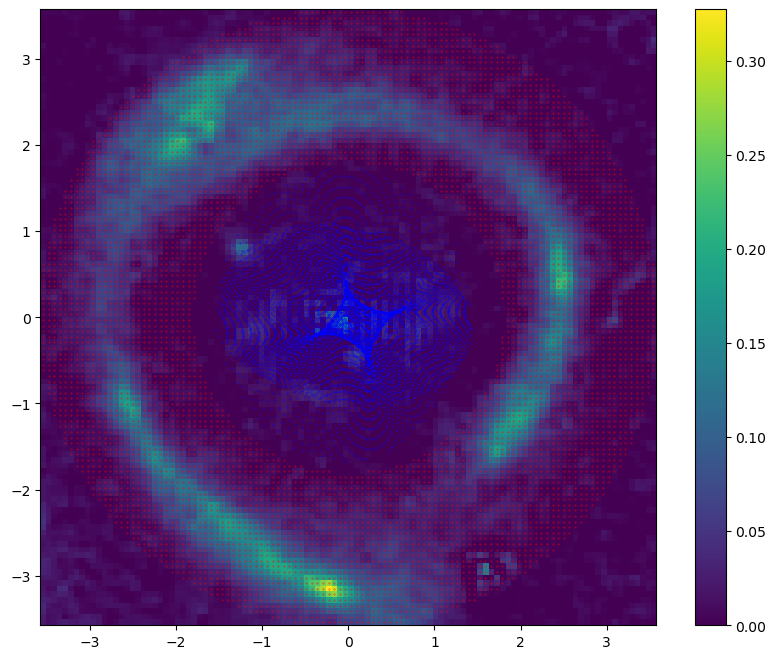

In [15]:
# x = [x_grid[ii] for ii in range(0,len(x_grid)) if np.sqrt(x_grid[ii]**2+y_grid[ii]**2)>1.8 and np.sqrt(x_grid[ii]**2+y_grid[ii]**2)<3.6 and x_grid[ii]<0 and y_grid[ii]<0]
# y = [y_grid[ii] for ii in range(0,len(y_grid)) if np.sqrt(x_grid[ii]**2+y_grid[ii]**2)>1.8 and np.sqrt(x_grid[ii]**2+y_grid[ii]**2)<3.6 and x_grid[ii]<0 and y_grid[ii]<0]
x = [x_grid[ii] for ii in range(0,len(x_grid)) if np.sqrt(x_grid[ii]**2+y_grid[ii]**2)>1.8 and np.sqrt(x_grid[ii]**2+y_grid[ii]**2)<3.6]
y = [y_grid[ii] for ii in range(0,len(y_grid)) if np.sqrt(x_grid[ii]**2+y_grid[ii]**2)>1.8 and np.sqrt(x_grid[ii]**2+y_grid[ii]**2)<3.6]


sim_config_noPSF = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=None)
lens_sim_noPSF = LensSimulator(phys_model_Forward, sim_config_noPSF, bs=1)
masssimulated_noPSF = lens_sim_noPSF.simulate([mass, [], source_light])

asdf = lensModel.ray_shooting(x,y,kwargs_lens)
plt.figure(figsize=(10,8))
ax = plt.plot
plt.plot(asdf[0],asdf[1],'b.', markersize=0.5)
plt.plot(x,y,'r.', markersize=0.5)

lensed = jnp.array(observed_img)-lenssimulated
lensed = lensed.clip(min=0)
#lensed = masssimulated
plt.imshow(lensed, extent=extent,origin='lower', cmap='viridis')
plt.colorbar()

In [16]:
from skimage import restoration
noPSF = restoration.richardson_lucy(lensed,psf)
#noPSF = masssimulated_noPSF

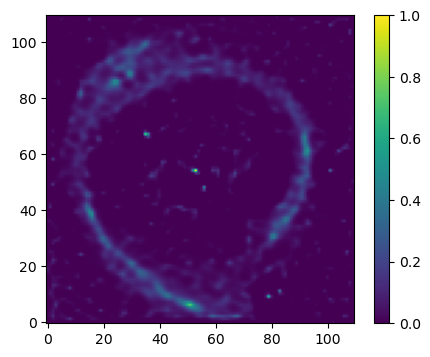

In [17]:
grid_offset = np.array([0, 0])
grid_spacing = np.array([1, 1])
qwerty = np.array(asdf)/0.065+55
points = np.transpose(qwerty)

gpoints = grid_offset + np.round((points - grid_offset) / grid_spacing) * grid_spacing
uniquepoints = np.unique(gpoints,axis=0)

plt.figure(figsize=(5,4))
# plt.plot(uniquepoints[:,0],uniquepoints[:,1],'b.')
# plt.plot(np.array(x)/0.065+55,np.array(y)/0.065+55,'r.')
plt.imshow(noPSF,origin='lower', cmap='viridis')
plt.colorbar()

In [18]:
total = np.zeros([110,110])
counter = np.zeros([110,110])
for point in np.transpose([x,y]):
    
    x_source, y_source = lensModel.ray_shooting(point[0],point[1],kwargs_lens)
    
    x_source = int(x_source/deltaPix+55)
    y_source = int(y_source/deltaPix+55)
    x_lensed, y_lensed = int(point[0]/deltaPix+55), int(point[1]/deltaPix+55)
    total[y_source,x_source] = total[y_source,x_source] + noPSF[y_lensed,x_lensed]
    counter[y_source,x_source] = counter[y_source,x_source] + 1
    #print(x_lensed, y_lensed, x_source, y_source)

In [19]:
delensed = np.divide(total, counter, out=np.zeros_like(total), where=counter!=0)

from astropy.convolution import convolve
delensed = convolve(delensed, psf, boundary='wrap')
delensed = delensed * np.max(sourcesimulated)/np.max(delensed)

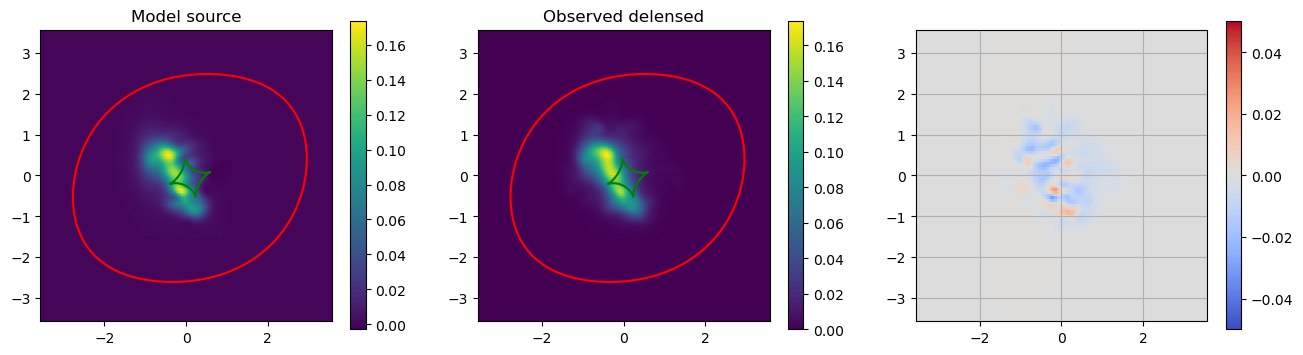

In [20]:
plt.figure(figsize=(16,4))

ax = plt.subplot(131)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(sourcesimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Model source")
plt.colorbar()

ax = plt.subplot(132)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(delensed, extent=extent, origin='lower', cmap='viridis')
plt.title("Observed delensed")
plt.colorbar()

plt.subplot(133)
plt.imshow(sourcesimulated-delensed, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-0.05,vmax=0.05)
plt.colorbar()
plt.grid()


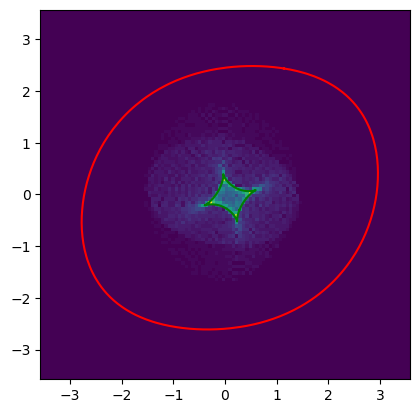

In [21]:
ax = plt.subplot(111)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(counter,origin='lower',extent=extent)